In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import shutil
from pathlib import Path
from yahooquery import Ticker

# STOCK = "aapl"
# DATASET_PATH = Path(".qlib")
# REG_DIR = DATASET_PATH / Path("us")
# STOCK_PATH = REG_DIR / Path(f"{STOCK}.csv")

# if os.path.exists(DATASET_PATH):
#     shutil.rmtree(DATASET_PATH)
# os.makedirs(REG_DIR)

# aapl = Ticker("aapl")
# price = aapl.history(period="max")

# price.to_csv(STOCK_PATH)

In [27]:
import qlib
from qlib.data import D
from qlib.constant import REG_CN, REG_US

start_date = "2012-01-01"
end_date = "2022-12-31"

target="Adj_Close"

fields_dict = {
    "Adj_Close": "$adjclose",
    "Open": "$open",
    "Close": "$close",
    "Open_Close_Diff": "$open-$close",
    "High": "$high",
    "Low": "$low",
    "Factor": "$adjclose/$close",
    "Volume": "$volume",
    "High_Low_Diff": "$high-$low",
    # "Open_EMA3": "EMA($open, 3)",
    # "Open_EMA5": "EMA($open, 5)",
    "Open_EMA10": "EMA($open, 10)",
    #"Close_EMA3": "EMA($close, 3)",
    #"Close_EMA5": "EMA($close, 5)",
    "Close_EMA10": "EMA($close, 10)",
}

provider_uri = ".qlib/qlib_data"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_US)
instruments = ["AAPL"]
fields = fields_dict.values()
len_feats = len(fields_dict)
target_index = list(fields_dict.keys()).index(target)
dataset = D.features(
    instruments, fields, start_time=start_date, end_time=end_date, freq="day"
).rename(columns={v: k for k, v in fields_dict.items()})
print(len(dataset))
dataset.isna().sum().sum()

[760212:MainThread](2023-11-24 23:29:14,783) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[760212:MainThread](2023-11-24 23:29:14,989) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[760212:MainThread](2023-11-24 23:29:14,990) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/mnt/Yeh/Dataset/ziyang/A3/.qlib/qlib_data')}


2768


0

In [6]:
dataset = dataset.loc["AAPL"]

In [7]:
from sklearn.model_selection import train_test_split

ratio = 0.8
train_data, test_data = train_test_split(dataset, train_size=ratio, shuffle=False)
train_data.shape, test_data.shape

((2214, 1), (554, 1))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(train_data)
df_for_testing_scaled=scaler.transform(test_data)

In [9]:
import numpy as np

def createXY(dataset,n_past, index=0):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, :])
            dataY.append(dataset[i,index])
    return np.array(dataX),np.array(dataY)        

In [10]:
train_steps = 50
test_steps = 50

trainX,trainY=createXY(df_for_training_scaled,train_steps,index=target_index)
testX,testY=createXY(df_for_testing_scaled,test_steps,index=target_index)
train_shape = trainX.shape[1:]
trainX.shape,trainY.shape,testX.shape,testY.shape

((2164, 50, 1), (2164,), (504, 50, 1), (504,))

In [28]:
import keras_core as keras
from keras_core.layers import *

def rnn_model(optimizer,shape,dropout=0.2):
    grid_model = keras.Sequential()
    grid_model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape=shape)))#manual change model
    grid_model.add(LSTM(64))
    grid_model.add(Dropout(dropout))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

Using TensorFlow backend


2023-11-24 23:29:21.868352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 23:29:21.868377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 23:29:21.869133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 23:29:21.873851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 23:29:22.505418: W tensorflow/compiler/tf2

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return keras.Model(inputs, outputs)



In [ ]:
def trans(optimizer,shape,dropout=0.2):
    tr = build_model(shape,
                     head_size=32,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.5,
        dropout=dropout,)
    tr.compile(loss = 'mse',optimizer = optimizer)
    return tr

In [ ]:
def fit_predit(times=5):
    pred_lst = []
    l1_lst = []
    l2_lst = []
    for _ in range(times):
        rnn = rnn_model('adam',train_shape) #for running transformer need to switch rnn_model to trans
        history = rnn.fit(trainX,trainY,batch_size=256,epochs=15)
        prediction=rnn.predict(testX)
        prediction_copies_array = np.repeat(prediction,len_feats, axis=-1)
        pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),len_feats)))[:,0]
        original_copies_array = np.repeat(testY,len_feats, axis=-1)
        original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),len_feats)))[:,0]
        mse = keras.losses.MeanSquaredError()
        l2=mse(pred, original).cpu().numpy()
        mae = keras.losses.MeanAbsoluteError()
        l1=mae(pred, original).cpu().numpy()
        pred_lst.append(pred)
        l2_lst.append(l2)
        l1_lst.append(l1)
        del rnn
    return pred_lst,l1_lst,l2_lst

In [ ]:
pred_lst,l1_lst,l2_lst=fit_predit(5)

/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2023-11-23 21:58:29.537020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 21:58:29.537048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 21:58:29.537783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 21:58:29.542257: I tensorflo

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0315
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0036
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0017
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0010
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5906e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.1925e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.9089e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 5.2397e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.6921e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 6.8873e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.0659e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5.6628e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.1405e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5.6663e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5

/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0442
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0049
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0024
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0014
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 9.8212e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.8300e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.1136e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 6.9134e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.9110e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.9003e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5.6285e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.8523e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.5747e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.8731e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5

/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0297
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0028
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0013
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0012
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 9.6089e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.8717e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.6282e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.4441e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.5710e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 6.1435e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.4841e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 6.7816e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 6.2012e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 6.1283e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 

/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0370
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0033
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0013
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.8790e-04
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 8.7419e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.6968e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.5470e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.5163e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.6565e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.1699e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 5.6338e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5.2011e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5.5359e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.5179e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - los

/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0514
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0052
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0027
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0018
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0011
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.1295e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 6.9469e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 7.2767e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 6.3491e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.6755e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.0348e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.3375e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.7810e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 7.5096e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 5.901

In [ ]:
pred_lst

[array([128.3953  , 128.88524 , 128.90833 , 128.99294 , 128.53743 ,
        128.482   , 128.54639 , 128.28917 , 128.00208 , 127.94354 ,
        127.69742 , 127.27162 , 126.92977 , 127.06858 , 127.78167 ,
        128.78232 , 130.20644 , 131.63254 , 132.86026 , 133.43198 ,
        133.29564 , 133.2411  , 133.19437 , 132.98923 , 133.12286 ,
        133.21576 , 133.32166 , 133.3256  , 133.2512  , 133.13837 ,
        133.04683 , 132.7248  , 132.1475  , 131.4507  , 130.79314 ,
        129.76602 , 128.7666  , 127.78508 , 126.42392 , 125.174286,
        124.74479 , 124.19029 , 123.41927 , 122.5225  , 121.84316 ,
        120.71288 , 120.16302 , 119.61054 , 119.369156, 119.12387 ,
        119.26823 , 119.65342 , 119.99717 , 119.89047 , 119.69267 ,
        119.84294 , 119.91353 , 119.71635 , 119.55622 , 119.463135,
        119.400246, 119.18822 , 119.22382 , 119.37462 , 119.85786 ,
        120.39391 , 121.10512 , 122.06062 , 123.26632 , 124.227295,
        125.43375 , 126.28653 , 127.27857 , 128.

In [ ]:
l1_lst

[array(4.195926, dtype=float32),
 array(3.8258152, dtype=float32),
 array(4.403019, dtype=float32),
 array(4.0918036, dtype=float32),
 array(4.16937, dtype=float32)]

In [ ]:
l2_lst

[array(28.057053, dtype=float32),
 array(23.565691, dtype=float32),
 array(30.871061, dtype=float32),
 array(26.878637, dtype=float32),
 array(27.114338, dtype=float32)]

In [ ]:
pred_value = np.array(pred_lst)
l1_value= np.array(l1_lst)
l2_value = np.array(l2_lst)

np.save('pred_value.npy', pred_value)

# Save l1_value to a file
np.save('l1_value.npy', l1_value)

# Save l2_value to a file
np.save('l2_value.npy', l2_value)

In [2]:
import numpy as np
import os
from glob import glob
dic_l1={}
dic_l2={}
dic_pred={}
for i in glob("result/*/*/l1*"):
    try:
        result = np.load(i,allow_pickle=True)
        result = result.mean().round(4)
    except:
        result = np.loadtxt(i)
        result = result.mean().round(4)
    dic_l1[i] = result
    
for i in glob("result/*/*/l2*"):
    try:
        result = np.load(i,allow_pickle=True)
        result = result.mean().round(4)
    except:
        result = np.loadtxt(i)
        result = result.mean().round(4)
    dic_l2[i] = result   
    
lst = ["One feature","Three feature","Five feature","Seven feature","Eight feature"]
dic_pred={k:{} for k in lst}
for item in lst:
    for i in glob(f"result/{item}/*/pred*"):
        model_name = str(i).split("/")[-2]
        try:
            result = np.load(i,allow_pickle=True).mean(axis=0)
        except:
            result = np.loadtxt(i).mean(axis=0) 
        dic_pred[item][model_name] = result  
        
dic_pred = {outer_key: dict(sorted(inner_dict.items()))
                      for outer_key, inner_dict in sorted(dic_pred.items())}



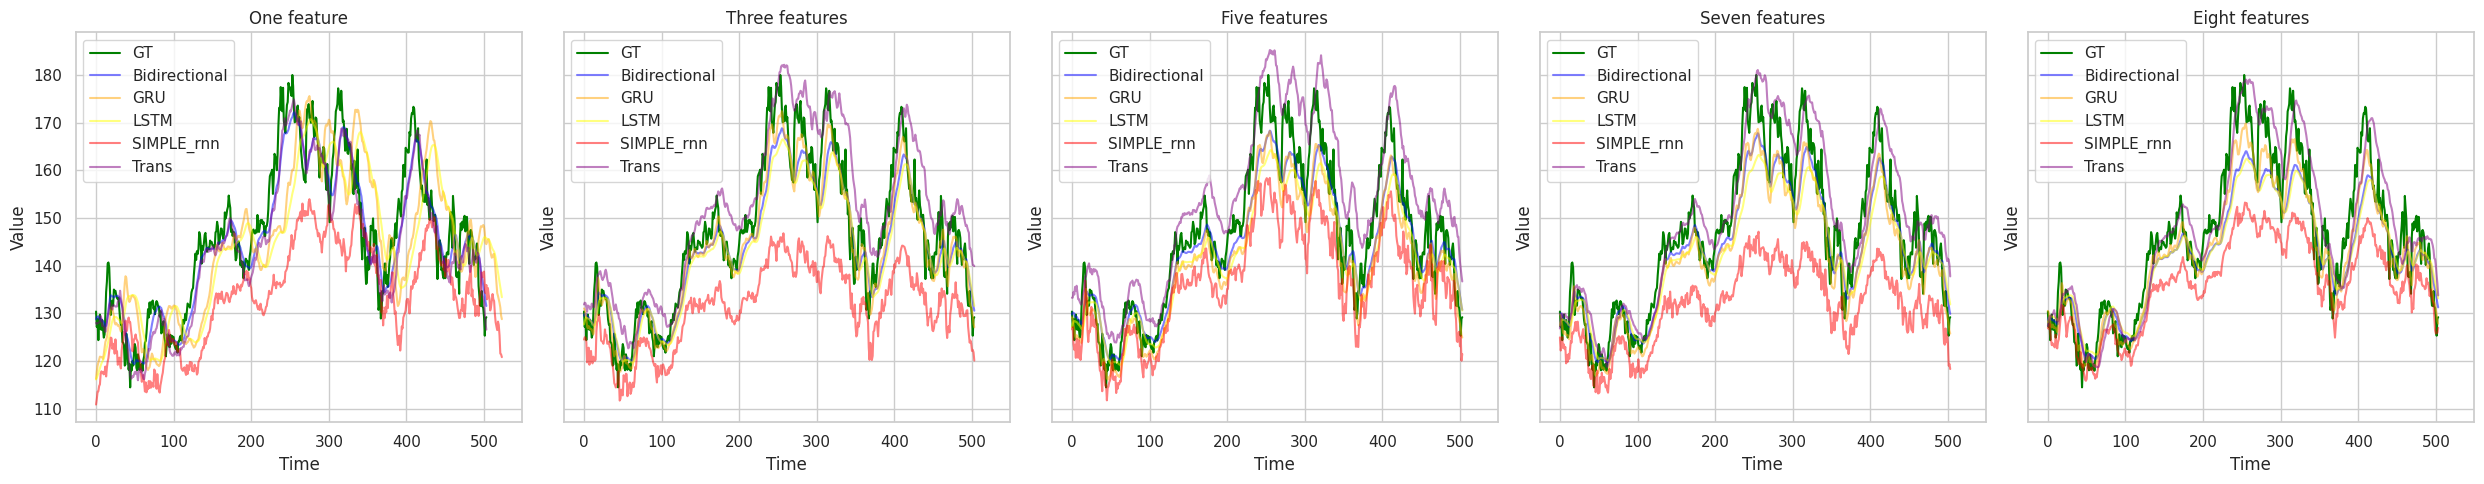

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

line_colors = ['blue', 'orange', 'yellow', 'red', 'purple']
ori = np.load('ori.npy')
sns.set(style='whitegrid')
sns.set_palette("husl")

fig, ax = plt.subplots(1, len(lst), figsize=(25, 5), sharex=True, sharey=True) 

for idx, model in enumerate(lst):
    ax[idx].plot(ori, label='GT', color='green')
    for j, (key, values) in enumerate(dic_pred[model].items()):
        ax[idx].plot(values, label=key, color=line_colors[j], alpha=0.5)

    ax[idx].set_xlabel('Time')
    ax[idx].set_ylabel('Value')
    ax[idx].set_title(f'{model if model.split(" ")[0]=="One" else model+"s"}')
    ax[idx].legend()

plt.tight_layout()
plt.show()#compare features in different model

In [4]:
lst = ['Bidirectional', 'GRU', 'LSTM', 'SIMPLE_rnn', 'Trans']
dic_pred={k:{} for k in lst}
for item in lst:
    for i in glob(f"result/*/{item}/pred*"):
        model_name = str(i).split("/")[-3]
        try:
            result = np.load(i,allow_pickle=True).mean(axis=0)
        except:
            result = np.loadtxt(i).mean(axis=0) 
        dic_pred[item][model_name] = result  
        
dic_pred = {outer_key: dict(sorted(inner_dict.items()))
                      for outer_key, inner_dict in sorted(dic_pred.items())}


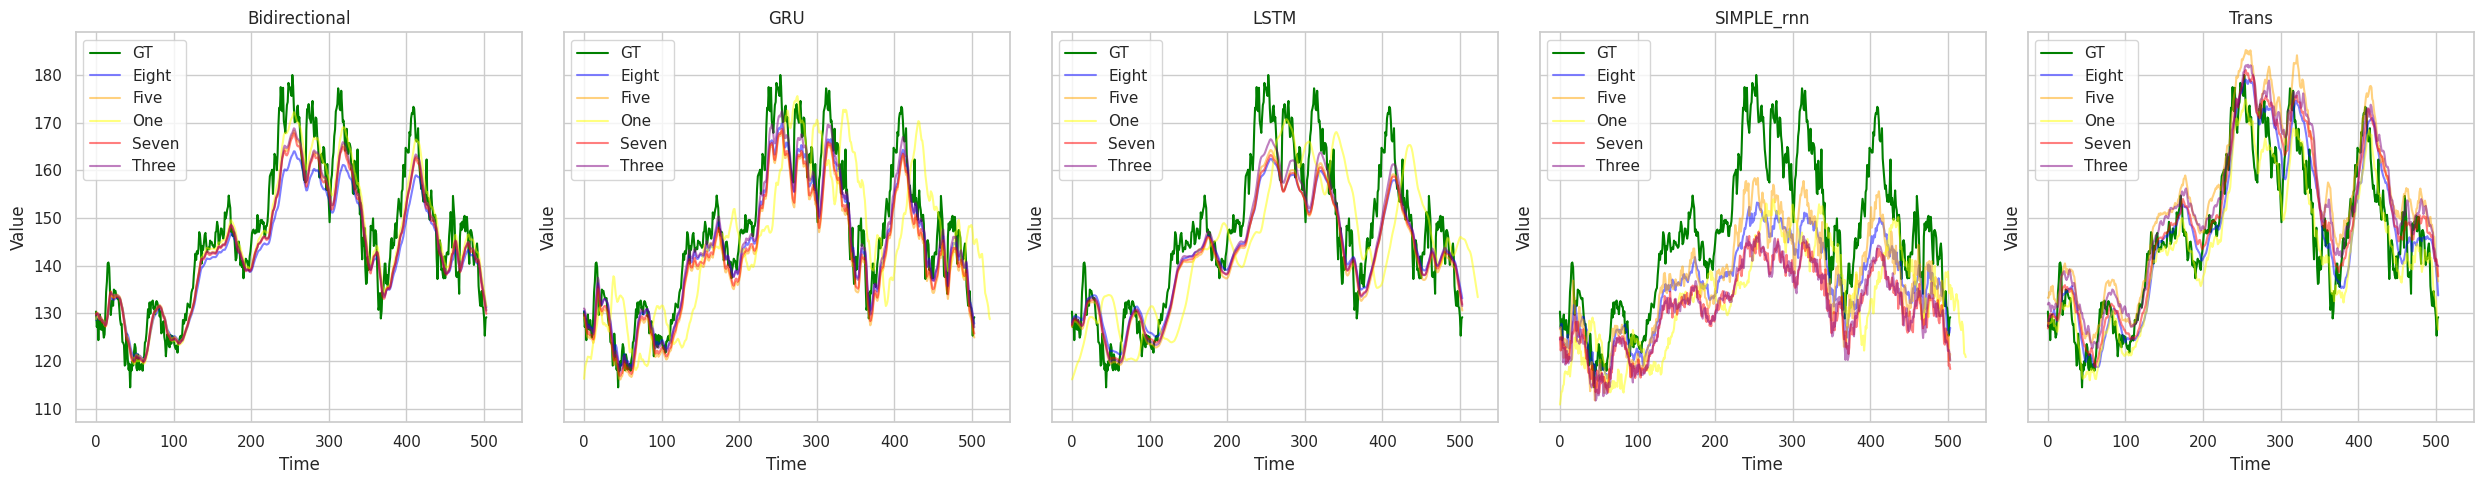

In [5]:
line_colors = ['blue', 'orange', 'yellow', 'red', 'purple']
ori = np.load('ori.npy')
sns.set(style='whitegrid')
sns.set_palette("husl")

fig, ax = plt.subplots(1, len(lst), figsize=(25, 5), sharex=True, sharey=True)  # Adjust figsize as needed

for idx, model in enumerate(lst):
    ax[idx].plot(ori, label='GT', color='green')
    for j, (key, values) in enumerate(dic_pred[model].items()):
        ax[idx].plot(values, label=key.split(" ")[0], color=line_colors[j], alpha=0.5)

    ax[idx].set_xlabel('Time')
    ax[idx].set_ylabel('Value')
    ax[idx].set_title(f'{model}')
    ax[idx].legend()

plt.tight_layout()
plt.show()#compare models in different features

In [26]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
def calculate_mape(y_true, y_pred):
   
    n = len(y_true)
    mape = (1/n) * sum([abs((y_true[i] - y_pred[i]) / y_true[i]) * 100 for i in range(n)])
    return mape.round(4)

y_true = np.load('ori.npy')

MAPE ={k:{} for k,_ in dic_pred.items()}
MSE ={k:{} for k,_ in dic_pred.items()}
for i in (lst):
    for j, (key, values) in enumerate(dic_pred[i].items()):
        if y_true.shape != values.shape:
            values = values[:-20]
        res1 = mean_absolute_percentage_error(y_true,values)
        res2 = mean_squared_error(y_true,values)
        MAPE[i][key] = res1
        MSE[i][key] = res2
import pandas as pd
pd.DataFrame.from_dict(MSE)

,Bidirectional,GRU,LSTM,SIMPLE_rnn,Trans
Eight feature,51.759354,27.765043,60.522926,154.711670,45.765377
Five feature,33.953922,44.350323,60.145042,120.057358,86.215820
One feature,26.914228,141.629959,152.503679,279.432983,32.212643
Seven feature,35.210312,38.188850,59.740738,292.123199,48.654911
Three feature,33.474220,21.281742,47.619255,288.604004,68.920090
